## Importing Libraries

In [40]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from matplotlib import cm
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.metrics import pair_confusion_matrix

%matplotlib inline

random_state = 42

## Load data

In [27]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:

data_file = '/content/drive/MyDrive/ML/Data/seeds_dataset.txt'
delimiter = '\t'
df = np.loadtxt(data_file, delimiter = delimiter)

## Separting X and y

In [29]:
X = df[:,:-1]
y = df[:,-1]

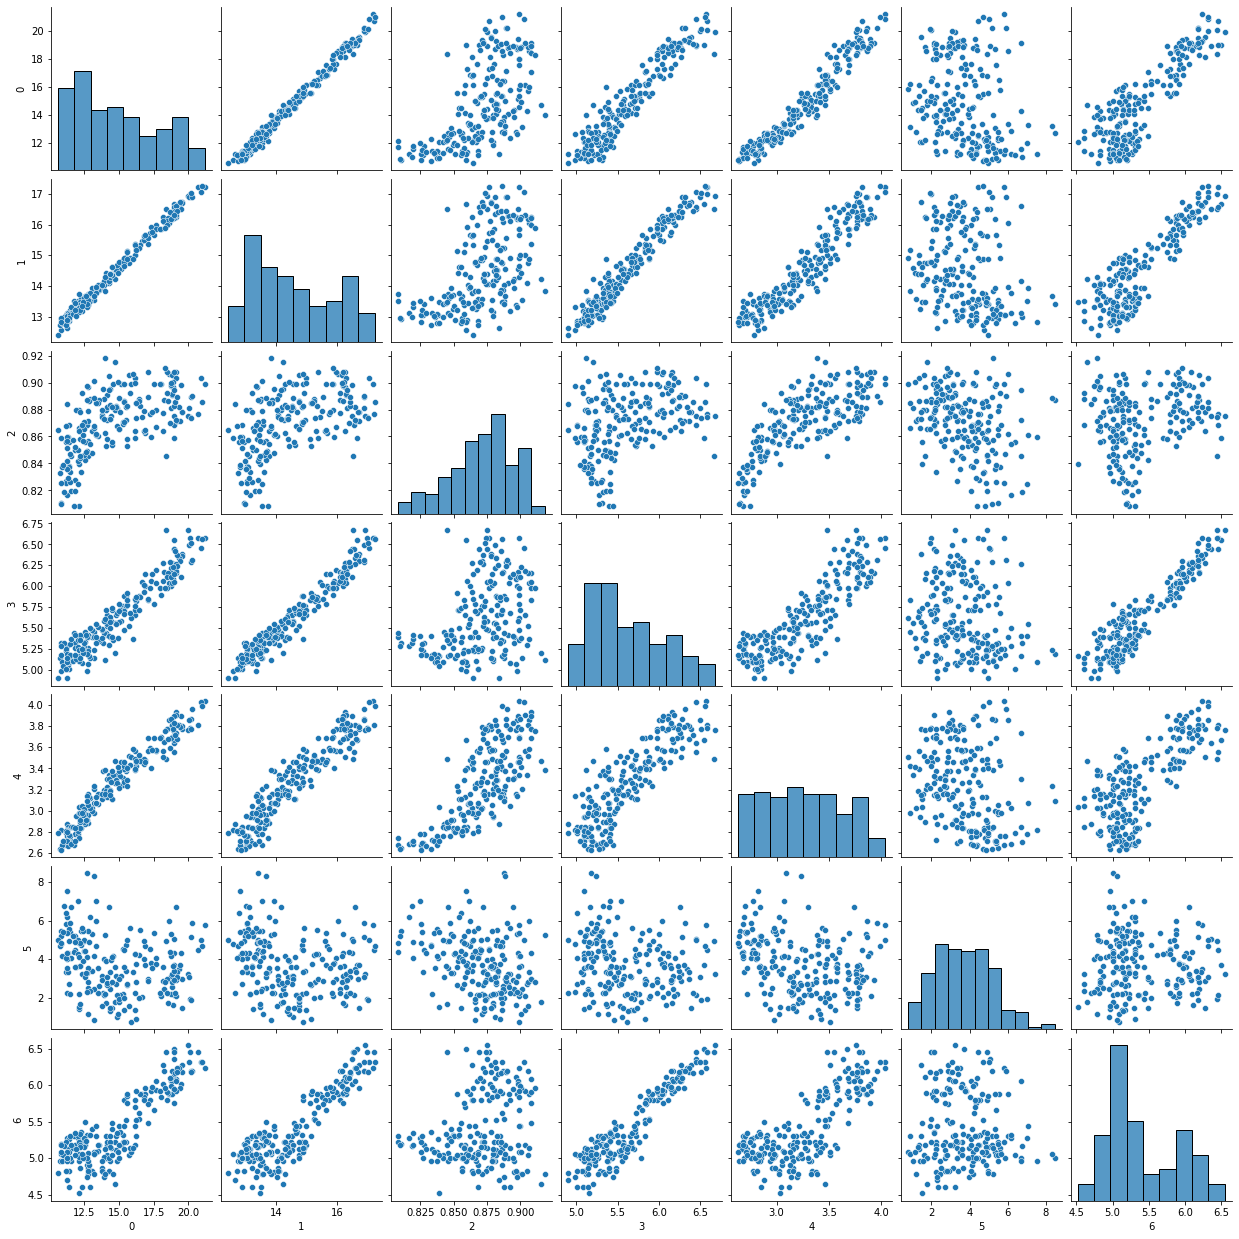

In [30]:
sns.pairplot(pd.DataFrame(X))

In [31]:
from sklearn.feature_selection import SelectKBest, SelectPercentile 
from sklearn.feature_selection import mutual_info_classif
from functools import partial

# k = num, num is the number of the best features that will be selected (e.g. if I start from 4 features k must be <4)

kbest = SelectKBest(score_func=partial(mutual_info_classif,random_state=random_state), k=num) 

fit = kbest.fit(X,y)
X_reducted = fit.transform(X)
X_reducted.shape

(210, 2)

In [32]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
     

In [46]:
def computing_best_clustering(X, k_range):
  #k_range = range(2,11) # set the range of k values to test 
  inertias = []
  silhouettes = []
  for i in k_range:
    k_model = KMeans(n_clusters = i, random_state = random_state)
    y_find = k_model.fit_predict(X)
    silhouette = silhouette_score(X, y_find)
    inertias.append(k_model.inertia_)
    silhouettes.append(silhouette)
  return inertias,silhouettes
     

In [47]:
k_range = list(range(2,11))
inertias, silhouettes = computing_best_clustering(X, k_range)

## Choice number of clusters

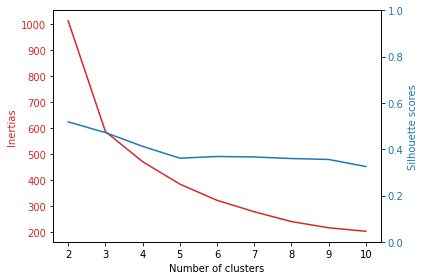

In [48]:
two_plots(x=k_range, y1=inertias, y2=silhouettes
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

The elbow plot and inertia suggested as best number of cluster 3

## Fit Clustering scheme

In [37]:
k = 3
model =  KMeans(n_clusters= k, random_state = random_state)
y_km = model.fit_predict(X)
print("Number of clusters {}, Inertia {:6.2f}, Silhouette {:4.2f}".format(k,inertias[k_range.index(k)],silhouettes[k_range.index(k)]))

Number of clusters 3, Inertia 587.32, Silhouette 0.47


## Gold Standard

In [42]:
def max_diag(sq_arr):
    """
    Given a square matrix produces another squared matrix with the same contents, 
    but the columns are re-orered in order to have the highest values in the main diagonal
    Parameter: sq_arr - a squared matrix
    Example:
    In [1]: import numpy as np
            max_diag(np.array([[1,10],[20,2]]))
    Out[1]: array([[10.,  1.],
                   [ 2., 20.]])
    This function is useful to reorder a confusion matrix when the two label vectors
    have different codings
    """
    import numpy as np
    if len(sq_arr.shape) != 2 or sq_arr.shape[0]!=sq_arr.shape[1]:
        return "Not a squared matrix"
    # find the position of the maximum value in each row
    max_pos = [np.argmax(sq_arr[i,:]) for i in range(sq_arr.shape[0])]
    if len(set(max_pos))!=sq_arr.shape[0]:
        return "There are columns with non unique maximum"
    sq_arr_sh = np.empty(sq_arr.shape)
    for i in range(sq_arr.shape[0]):
        sq_arr_sh[:,i] = sq_arr[:,max_pos[i]]
    return(sq_arr_sh)

In [43]:
pcm = pair_confusion_matrix(y, y_km)
conf_matrix = pcm / pcm.sum()
print(max_diag(conf_matrix))

[[0.60551378 0.06434267]
 [0.06128959 0.26885395]]


In [44]:
print("The percentage of match between the two clustering schemes is {:6.2f}%".format((conf_matrix).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  87.44%


## rescale X using sklearn.preprocessing.MinMaxScaler, producing the scaled dataset X_mms (3pt) 7. repeat point 3 and 5 above, fitting X_mms to y_km_mms and producing the confusion matrix cm_km_mms reordered with max_diag and the accuracy a_km_mms as above (3pt)

In [49]:
minMax = MinMaxScaler()
X_scale = pd.DataFrame(minMax.fit_transform(X))
X_scale.head()

,0,1,2,3,4,5,6
0,0.440982,0.502066,0.570780,0.486486,0.486101,0.189302,0.345150
1,0.405099,0.446281,0.662432,0.368806,0.501069,0.032883,0.215165
2,0.349386,0.347107,0.879310,0.220721,0.503920,0.251453,0.150665
3,0.306893,0.316116,0.793103,0.239302,0.533856,0.194243,0.140817
4,0.524079,0.533058,0.864791,0.427365,0.664291,0.076701,0.322994


In [50]:
inertias, silhouettes = computing_best_clustering(X_scale, k_range)

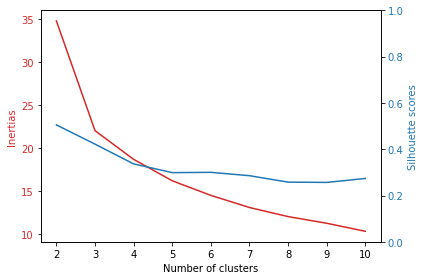

In [51]:
two_plots(x=k_range, y1=inertias, y2=silhouettes
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

In [52]:
best_model =  KMeans(n_clusters= k, random_state = random_state)
y_best = best_model.fit_predict(X_scale)
print("Number of clusters {}, Inertia {:6.2f}, Silhouette {:4.2f}".format(k,inertias[k_range.index(k)],silhouettes[k_range.index(k)]))

Number of clusters 3, Inertia  22.02, Silhouette 0.42


In [53]:
pcm = pair_confusion_matrix(y_best, y_km)
conf_matrix = pcm / pcm.sum()
print(max_diag(conf_matrix))

[[0.63331055 0.03458647]
 [0.03349282 0.29861016]]


In [54]:
print("The percentage of match between the two clustering schemes is {:6.2f}%".format((conf_matrix).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  93.19%
